Note: figure 3 panels D and E were actually generated in the previous notebook (03).

In [1]:
suppressPackageStartupMessages({
    library(monocle)
    
    library(RColorBrewer)
    library(dplyr)
    library(ggplot2)
    library(pheatmap)
    library(reshape2)
    library(scales)
})

Warning message:
“replacing previous import by ‘splines::splineDesign’ when loading ‘VGAM’”Warning message:
“replacing previous import by ‘grid::arrow’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘grid::unit’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘igraph::clusters’ when loading ‘monocle’”Warning message:
“replacing previous import by ‘ggplot2::Position’ when loading ‘monocle’”

This analysis was made using Monocle version 2.3.5. The source code for Monocle 2.3.5 is available as a supplementary file to Cao et al. 2017 on the Science website. We are working on updating the analysis to the latest version of Monocle.

In [3]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-unknown-linux-gnu (64-bit)
Running under: CentOS release 6.8 (Final)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] splines   stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] scales_0.4.1        reshape2_1.4.2      pheatmap_1.0.8     
 [4] dplyr_0.7.1         RColorBrewer_1.1-2  monocle_2.3.5      
 [7] DDRTree_0.1.5       irlba_2.2.1         VGAM_1.0-3         
[10] ggplot2_2.2.1       Biobase_2.30.0      BiocGenerics_0.16.1
[13] Matrix_1.2-7.1     

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.11           bind

In [ ]:
# at certain "checkpoints" in this notebook, we save our progress to this RData file
# run this cell to load your progress if you have already reached through one or more checkpoints in the notebook

# IF YOU RUN THIS CELL DO NOT RUN THE CELL BELOW

load("RData/L2.main.figure.RData")

In [4]:
load("RData/L2.data.summaries.RData")

In [4]:
theme_set(theme_bw(base_size=6))

In [4]:
pData(cds.experiment.1)$cluster.name = ifelse(
    pData(cds.experiment.1)$cluster.name == "Low coverage or uncluster",
    "Low coverage or unclear", pData(cds.experiment.1)$cluster.name)

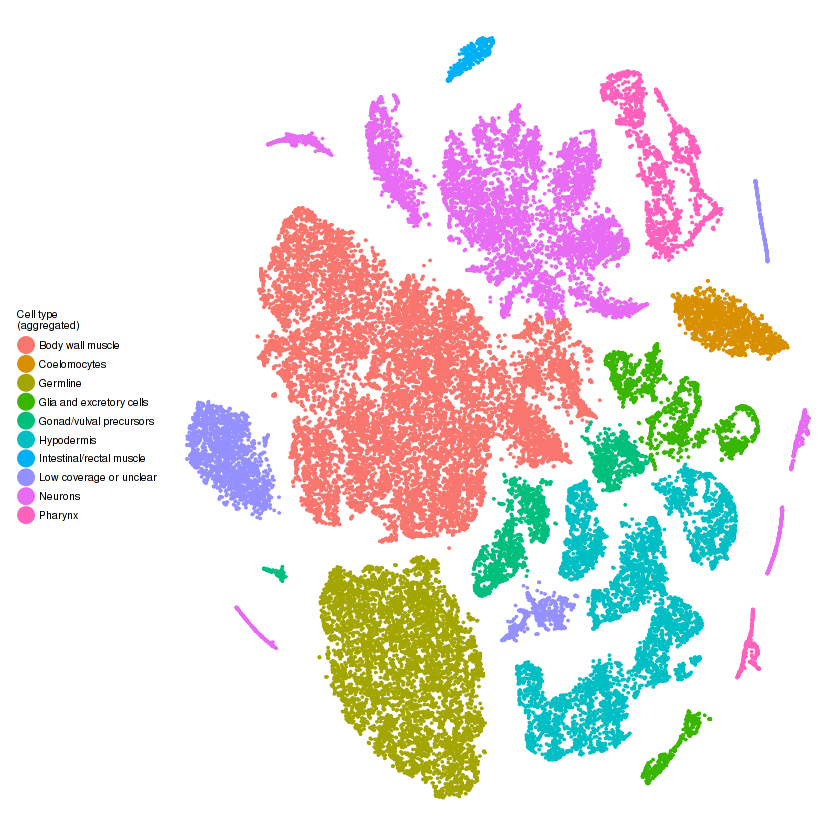

In [5]:
plot = ggplot(pData(cds.experiment.1), aes(x = tsne_1, y = tsne_2, color = cluster.name)) +
    geom_point(size = 0.002) +
    xlab("") + ylab("") +
    guides(color = guide_legend(
        title = "Cell type\n(aggregated)",
        override.aes = list(size = 4))) +
    theme_void() +
    monocle:::monocle_theme_opts() +
    theme(legend.title = element_text(size=6),
          legend.text = element_text(size=6),
          legend.margin = margin(0, -10, 0, 10),
          legend.key.width=unit(0.15, "in"),
          legend.key.height=unit(0.15, "in"),
          legend.position = "left")

show(plot)

ggsave(
    "plots/Fig_3A.png",
    plot=plot, units="in", width=3.0, height=2.5, dpi=300)

In [11]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/C.elegans.L2.L3.bulk.RNA-seq.dcpm.tsv.gz",
    destfile = "RData/C.elegans.L2.L3.bulk.RNA-seq.dcpm.tsv.gz")

In [12]:
bulk.mat = as.matrix(
    read.table(gzfile("RData/C.elegans.L2.L3.bulk.RNA-seq.dcpm.tsv.gz"),
    header=T, row.names=1,
    colClasses=c("character", rep("numeric", 4))))

In [13]:
dim(bulk.mat)

[1] 20391     4

In [14]:
download.file(
    "http://jpacker-data.s3.amazonaws.com/public/C.elegans.WB253.seq.id.to.gene.symbol.tsv",
    destfile = "RData/C.elegans.WB253.seq.id.to.gene.symbol.tsv")

In [15]:
seq.id.to.symbol = read.table(
    "RData/C.elegans.WB253.seq.id.to.gene.symbol.tsv",
    col.names = c("seq.id", "gene"),
    colClasses = c("character", "character"))

In [16]:
bulk.df = as.data.frame(bulk.mat)
bulk.df$gene = rownames(bulk.df)

bulk.df$L2.tpm = sqrt(bulk.df$L2_dcpm * bulk.df$N2_L2.4_dcpm)
bulk.df$L3.tpm = sqrt(bulk.df$L3_dcpm * bulk.df$N2_L3.1_dcpm)

bulk.df$L2.tpm = (bulk.df$L2.tpm / sum(bulk.df$L2.tpm)) * 1000000
bulk.df$L3.tpm = (bulk.df$L3.tpm / sum(bulk.df$L3.tpm)) * 1000000

bulk.df = seq.id.to.symbol %>%
    inner_join(bulk.df, by = c("seq.id" = "gene")) %>%
    select(gene, L2.tpm, L3.tpm)

dim(bulk.df)
head(bulk.df)

[1] 19783     3

gene,L2.tpm,L3.tpm
2L52.1,2.401663,1.2611549
2RSSE.1,21.678465,14.9479397
pot-3,3.851572,6.9164590
nas-6,17.400592,2.6555617
4R79.2,2.424504,0.8817743
6R55.2,3.135678,0.9404265


In [17]:
expr.sums.1 = rowSums(exprs(cds.experiment.1))
expr.sums.2 = rowSums(exprs(cds.experiment.1)) +
    rowSums(exprs(cds.experiment.2)[, with(pData(cds.experiment.2), !is.na(tissue) & tissue == "Intestine")])

names(expr.sums.1) = fData(cds)$symbol
names(expr.sums.2) = fData(cds)$symbol

In [18]:
bulk.comparison.df = bulk.df %>% inner_join(
    data.frame(
        gene = fData(cds)$symbol,
        sci.1.tpm = (expr.sums.1 / sum(expr.sums.1)) * 1000000,
        sci.2.tpm = (expr.sums.2 / sum(expr.sums.2)) * 1000000),
    by = "gene")

nrow(bulk.comparison.df)
head(bulk.comparison.df)

Warning message:
“Column `gene` joining character vector and factor, coercing into character vector”

[1] 19783

gene,L2.tpm,L3.tpm,sci.1.tpm,sci.2.tpm
2L52.1,2.401663,1.2611549,17.8750057,18.3886577
2RSSE.1,21.678465,14.9479397,25.4448480,26.1366876
pot-3,3.851572,6.9164590,4.3680322,4.3182354
nas-6,17.400592,2.6555617,13.2313210,12.9547061
4R79.2,2.424504,0.8817743,7.9727191,7.7686913
6R55.2,3.135678,0.9404265,0.1696323,0.1859527


In [19]:
cor(bulk.comparison.df$sci.1.tpm, bulk.comparison.df$L2.tpm, method="spearman")
cor(bulk.comparison.df$sci.2.tpm, bulk.comparison.df$L2.tpm, method="spearman")

[1] 0.7960308

[1] 0.8235624

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 7078 rows containing non-finite values (stat_smooth).”Warning message in grid.Call.graphics(L_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 7078 rows containing non-finite values (stat_smooth).”

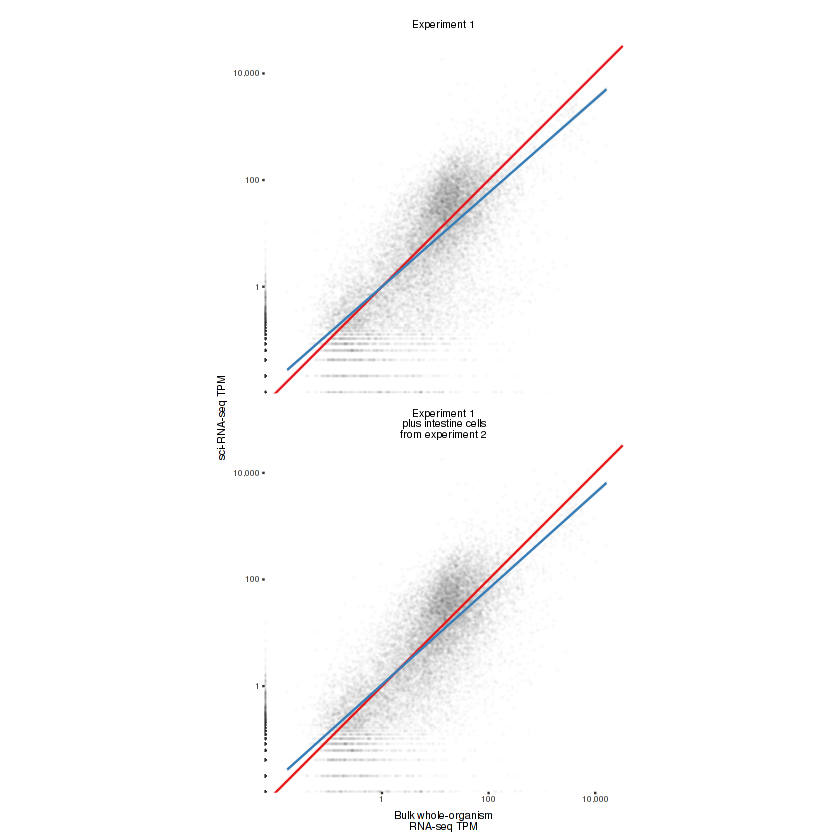

In [20]:
tmp.df = melt(bulk.comparison.df %>% select(gene, L2.tpm, sci.1.tpm, sci.2.tpm),
    id.vars = c("gene", "L2.tpm"), variable.name = c("zork"), value.name = "value")

tmp.df$zork = ifelse(tmp.df$zork == "sci.1.tpm",
    "Experiment 1", "Experiment 1\nplus intestine cells\nfrom experiment 2")

tmp.df$zork = factor(tmp.df$zork, levels = unique(tmp.df$zork))

plot = ggplot(tmp.df, aes(x = L2.tpm, y = value)) +
    facet_wrap(~ zork, ncol = 1) +
    geom_point(size = 0.01, alpha = 0.01333) +
    geom_abline(color = "#E41A1C", size = 0.5) +
    geom_smooth(method = "lm", color = "#377EB8", size = 0.5) +
    scale_x_log10(labels = comma, breaks = c(1, 100, 10000)) +
    scale_y_log10(labels = comma, breaks = c(1, 100, 10000)) +
    coord_fixed() +
    ylab("sci-RNA-seq TPM") +
    xlab("Bulk whole-organism\nRNA-seq TPM") +
    theme_bw(base_size = 6) +
    monocle:::monocle_theme_opts() +
    theme(axis.title.x = element_text(margin = margin(5, 0, 0, 0), color = "black"),
          axis.title.y = element_text(margin = margin(0, 2, 0, 0), color = "black"),
          strip.text.x = element_text(size = 6, color = "black"),
          panel.spacing = unit(0.5, "lines"))

show(plot)

ggsave("plots/Fig_3C.pdf",
    device = cairo_pdf, plot = plot, units = "in", width = 1.25, height = 2.5)

In [21]:
cell.types = c(
    "Body wall muscle",
    "Intestinal/rectal muscle",
    "Pharyngeal muscle",
    "Pharyngeal epithelia",
    "Pharyngeal gland",
    "Seam cells",
    "Non-seam hypodermis",
    "Total neurons",
    "Cholinergic neurons",
    "Ciliated sensory neurons",
    "Other interneurons",
    "GABAergic neurons",
    "Touch receptor neurons",
    "Pharyngeal neurons",
    "Oxygen sensory neurons",
    "Canal associated neurons",
    "flp-1(+) interneurons",
    "Total glia",
    "Am/PH sheath cells",
    "Socket cells",
    "Somatic gonad precursors",
    "Distal tip cells",
    "Vulval precursors",
    "Sex myoblasts",
    "Intestine",
    "Coelomocytes",
    "Rectum",
    "Excretory cells",
    "Other cell types")

In [22]:
tmp = data.frame(pData(cds) %>% group_by(cell.type) %>% summarize(n = n()) %>% filter(!is.na(cell.type)))
tmp$cell.type = ifelse(tmp$cell.type == "Pharyngeal.neurons", "Pharyngeal neurons", tmp$cell.type)
rownames(tmp) = tmp$cell.type
tmp[cell.types,]

,cell.type,n
Body wall muscle,Body wall muscle,9722
Intestinal/rectal muscle,Intestinal/rectal muscle,308
Pharyngeal muscle,Pharyngeal muscle,330
Pharyngeal epithelia,Pharyngeal epithelia,747
Pharyngeal gland,Pharyngeal gland,261
Seam cells,Seam cells,3273
Non-seam hypodermis,Non-seam hypodermis,1196
NA,NA,NA
Cholinergic neurons,Cholinergic neurons,1015
Ciliated sensory neurons,Ciliated sensory neurons,842


In [23]:
dim(cds.experiment.1)

Features  Samples 
   20271    42035

In [24]:
nrow(pData(cds.experiment.1)) -
    sum(pData(cds.experiment.1)$cluster.name == "Germline") -
    sum(pData(cds.experiment.1)$cluster.name == "Low coverage or unclear") -
    length(doublet.ids.experiment.1)

[1] 32856

In [25]:
cell.type.umi.sums = sapply(setdiff(unique(pData(cds.experiment.1)$cell.type), NA), function(x) {
    sum(colSums(exprs(cds.experiment.1)[, with(pData(cds.experiment.1), !is.na(cell.type) & cell.type == x)]))
})

In [26]:
tmp = sum(colSums(exprs(cds.experiment.2)[,
    with(pData(cds.experiment.2), !is.na(tissue) & tissue == "Intestine")]))
names(tmp) = "Intestine"

cell.type.umi.sums = c(cell.type.umi.sums, tmp)
rm(tmp)

cell.type.umi.sums[sub("Pharyngeal neurons", "Pharyngeal.neurons", cell.types)]

Body wall muscle Intestinal/rectal muscle        Pharyngeal muscle 
                19601088                   444461                   297793 
    Pharyngeal epithelia         Pharyngeal gland               Seam cells 
                  405019                   227805                  4511869 
     Non-seam hypodermis                     <NA>      Cholinergic neurons 
                 1068013                       NA                   359605 
Ciliated sensory neurons       Other interneurons        GABAergic neurons 
                  276100                   172852                    95965 
  Touch receptor neurons                     <NA>   Oxygen sensory neurons 
                  103343                       NA                    90374 
Canal associated neurons    flp-1(+) interneurons                     <NA> 
                   76643                    96267                       NA 
      Am/PH sheath cells             Socket cells Somatic gonad precursors 
                  515852                   184774                   827863 
        Distal tip cells        Vulval precursors            Sex myoblasts 
                  204972                   572620                   379529 
               Intestine             Coelomocytes                   Rectum 
                 1238576                   544263                   164609 
         Excretory cells                     <NA> 
                  136551                       NA

In [27]:
cell.type.counts = data.frame(
    cell.type = cell.types,
    count = c(
        10508, 338, 332, 747, 271,
        3523, 1268, 6825, 1015, 842,
        443, 400, 334, 314, 305,
        239, 224, 987, 421, 358,
        355, 129, 488, 302, 0,
        1358, 121, 155, 0),
    expected.per.L2.worm = c(
        95, 4, 37, 27, 5,
        32, 126, 302, 103, 40,
        83 - 14, 26, 6, 20, 10,
        2, 14, 56, 4, 26,
        10, 2, 3, 2, 34,
        6, 8, 4, 9),
    umi.total = c(
        19601088, 444461, 297793, 405019, 227805,
        4511869, 1068013, 2088753, 359605, 276100,
        172852, 95965, 103343, 85381, 90374,
        76643, 96267, 796260, 515852, 184774,
        827863, 204972, 572620, 379529, 1238576,
        544263, 164609, 136551, 0)) %>%
    mutate(
        prop.sci = count / 32856,
        prop.in.L2.worm = expected.per.L2.worm / 762)

cell.type.counts = arrange(cell.type.counts, prop.in.L2.worm)
cell.type.counts$cell.type = factor(
    cell.type.counts$cell.type, levels = cell.type.counts$cell.type)

In [28]:
cell.type.counts %>% mutate(ratio = prop.sci / prop.in.L2.worm) %>% arrange(-ratio)

cell.type,count,expected.per.L2.worm,umi.total,prop.sci,prop.in.L2.worm,ratio
Coelomocytes,1358,6,544263,0.041331872,0.007874016,5.2491478
Vulval precursors,488,3,572620,0.014852691,0.003937008,3.7725834
Sex myoblasts,302,2,379529,0.009191624,0.002624672,3.5020088
Canal associated neurons,239,2,76643,0.007274166,0.002624672,2.7714573
Body wall muscle,10508,95,19601088,0.319819820,0.124671916,2.5652916
Seam cells,3523,32,4511869,0.107225469,0.041994751,2.5533065
Am/PH sheath cells,421,4,515852,0.012813489,0.005249344,2.4409697
Intestinal/rectal muscle,338,4,444461,0.010287314,0.005249344,1.9597334
Distal tip cells,129,2,204972,0.003926224,0.002624672,1.4958912
Touch receptor neurons,334,6,103343,0.010165571,0.007874016,1.2910275


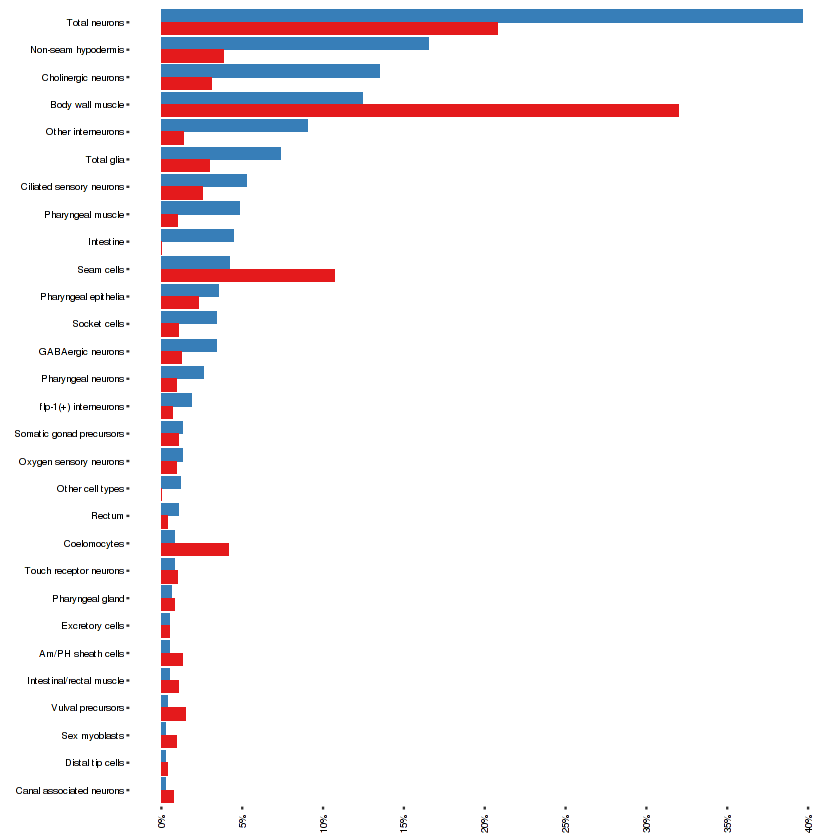

In [29]:
tmp.df = melt(cell.type.counts[, c("cell.type", "umi.total", "prop.in.L2.worm", "prop.sci")],
    id.vars=c("cell.type", "umi.total"), variable.name = "group", value.name = "proportion")

tmp.df$group = factor(tmp.df$group, levels = c("prop.sci", "prop.in.L2.worm"))

plot = ggplot(tmp.df, aes(x = cell.type, y = proportion, fill = group)) +
    geom_bar(stat = "identity", position = "dodge") +
    #geom_text(aes(
    #    label = prettyNum(umi.total, big.mark = ","), y = proportion + 0.01,
    #    group = group, alpha = group), position = position_dodge(1.0), size = 1.2) +
    scale_y_continuous(breaks = seq(0, 1, 0.05), labels = percent) +
    scale_fill_manual(
        labels = c("In individual worm", "Identifiable in\nsci-RNA-seq data"),
        values = brewer.pal(3, "Set1")[1:2]) +
    #scale_alpha_manual(values = c(1, 0)) +
    xlab("") + ylab("") +
    coord_flip() +
    guides(fill = F, alpha = F) +
    theme_bw(base_size = 7) +
    monocle:::monocle_theme_opts() +
    theme(
        axis.title.x = element_text(margin = margin(-5, 0, 0, 0)),
        axis.title.y = element_text(angle = 0, vjust = 0.6, margin = margin(0, 5, 0, 0)),
        axis.text.x = element_text(
            angle = 90, hjust = 1.0, vjust = 0.5, margin = margin(3, 0, 0, 0),
            color = "black"),
        axis.text.y = element_text(color = "black"))

show(plot)

ggsave("plots/Fig_3B.png",
    plot = plot, units = "in", width = 2.5, height = 4.05)

In [30]:
colnames(cell.type.norm.means)

[1] "Unclassified neurons"     "Germline"                
 [3] "Intestinal/rectal muscle" "Coelomocytes"            
 [5] "Ciliated sensory neurons" "Seam cells"              
 [7] "Non-seam hypodermis"      "Pharyngeal epithelia"    
 [9] "Touch receptor neurons"   "Body wall muscle"        
[11] "Cholinergic neurons"      "Distal tip cells"        
[13] "Vulval precursors"        "Other interneurons"      
[15] "GABAergic neurons"        "Am/PH sheath cells"      
[17] "Pharyngeal muscle"        "Pharyngeal neurons"      
[19] "Oxygen sensory neurons"   "Somatic gonad precursors"
[21] "flp-1(+) interneurons"    "Canal associated neurons"
[23] "Unclassified glia"        "Pharyngeal gland"        
[25] "Sex myoblasts"            "Excretory cells"         
[27] "Dopaminergic neurons"     "Socket cells"            
[29] "Rectum"                   "Intestine"

In [31]:
mat = cell.type.norm.means[, colnames(cell.type.norm.means) != "Dopaminergic neurons"]
rownames(mat) = fData(cds)$symbol
mat = mat[apply(mat, 1, max) >= 0.05,]
mat = log2(mat+1)
mat = t(scale(t(mat)))
mat = ifelse(mat < -2.0, -2.0, mat)
mat = ifelse(mat > 2.0, 2.0, mat)

dim(mat)

[1] 8613   29

PNG 
  2

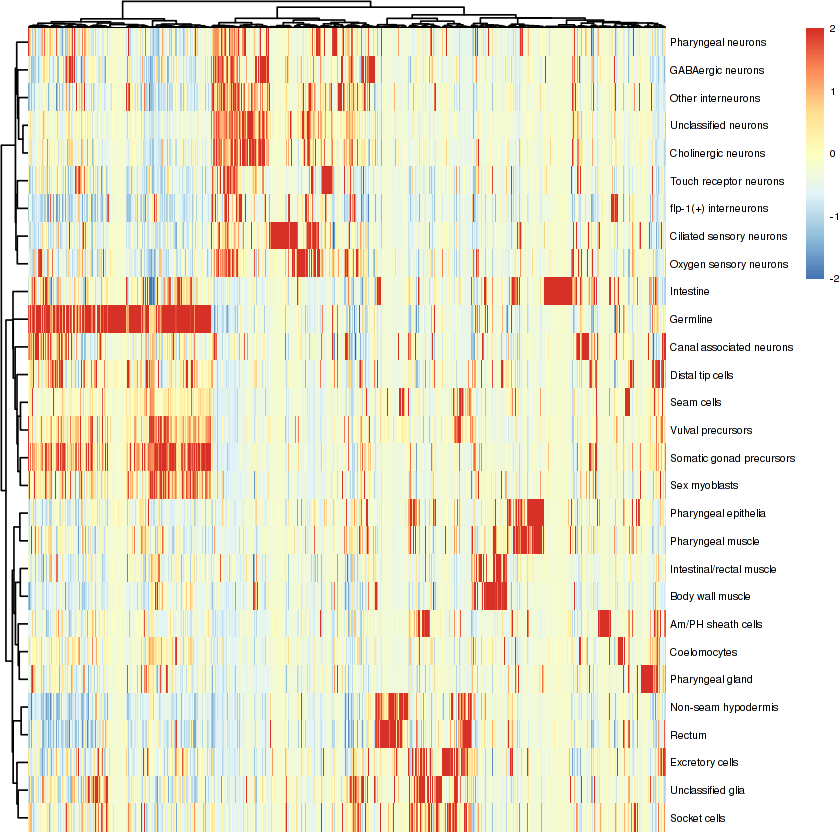

In [32]:
png("plots/Fig_3F.png", units="in", res=300, width=3.0, height=4.05)
pheatmap(t(mat), show_colnames = F, clustering_method = "ward.D2",
    fontsize = 6, treeheight_col = 12, treeheight_row = 12)
dev.off()

In [33]:
zork = fData(cds)[, c("gene_id", "symbol")]
zork$in.fig.3f = ifelse(zork$symbol %in% rownames(mat), 1, 0)
zork$in.fig.4c = ifelse(zork$symbol %in% ts.gene.lists[["Neurons"]], 1, 0)

In [34]:
head(zork)

,gene_id,symbol,in.fig.3f,in.fig.4c
WBGene00000001,WBGene00000001,aap-1,0,0
WBGene00000002,WBGene00000002,aat-1,1,0
WBGene00000003,WBGene00000003,aat-2,1,0
WBGene00000004,WBGene00000004,aat-3,1,0
WBGene00000005,WBGene00000005,aat-4,0,0
WBGene00000006,WBGene00000006,aat-5,1,0


In [35]:
write.table(zork, file = "tables/Table_S14.tsv",
    sep = "\t", row.names = F, col.names = T, quote = F)

In [43]:
save.image("RData/L2.main.figure.RData")